# Initialization

In [1]:
from __future__ import print_function


from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard,ReduceLROnPlateau
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
from keras.layers import AveragePooling2D, Multiply, Concatenate, Add

import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pickle

import os, cv2
from preprocessing import BatchGenerator
from utils import decode_netout, draw_boxes

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

from keras.regularizers import l2
from keras.models import Model
from keras.applications.mobilenet import MobileNet
from keras.applications.xception import Xception
from keras.layers.merge import concatenate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os


Using TensorFlow backend.


In [2]:
# from keras.applications.resnext import ResNeXt101

# resnext_m = ResNeXt101(include_top=False, weights='imagenet')
# keras.applications.resnext.ResNeXt101(include_top=True, weights='imagenet', input_shape=None)

In [3]:
# import keras

# # res_m = keras.applications.resnext.ResNeXt101(include_top=False, weights=None)


# xm = keras.applications.xception.Xception(include_top=False, weights=None, input_shape=(224,224,3))
# xm.output

In [4]:
# res_m = keras.applications.resnet50.ResNet50(include_top=False, weights=None, input_shape=(224,224,3))
# res_m.summary()

In [5]:
# xm.save_weights('xception-m.h5')

In [2]:
import xml.etree.ElementTree as ET

def parse_annotation(ann_dir, img_dir, labels=[]):
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = img_dir + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] = 1
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

In [3]:
train_image_folder = '../../coco-data/VOCdevkit/VOC2012/JPEGImages/'
train_annot_folder = '../../coco-data/VOCdevkit/VOC2012/Annotations/'

# valid_image_folder = '/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data/val-images/'
# valid_annot_folder = '/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data/val-annotations/'

train_imgs, seen_train_labels = parse_annotation(train_annot_folder, train_image_folder)


In [4]:
len(train_imgs)

17125

In [5]:
# len(list(seen_train_labels.keys())), seen_train_labels.values()

In [6]:
# df_test          = pd.read_csv('data/level3_data/test.csv')
# df               = pd.read_csv('data/level3_data/training_set.csv')

# train_dir        = 'data/train/images/'
# test_dir         = 'data/train/images/'
LABELS           = list(seen_train_labels.keys())#['obj']
BOX              = 5
CLASS            = len(LABELS)
wts              = list(seen_train_labels.values())
wts              = wts/np.sum(wts)
# CLASS_WEIGHTS    = wts.astype('float32')#np.ones(CLASS, dtype='float32')
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.5
NMS_THRESHOLD    = 0.45

####################
# anchors when we have grid-size of 7
# ANCHORS          = [1.99,4.15, 3.78,5.13, 4.78,2.38, 5.99,3.60, 6.15,5.81]
####################

ANCHORS = [0.96,1.49, 2.44,4.30, 4.26,8.73, 7.94,5.31, 10.04,10.85]

IMAGE_H, IMAGE_W = 224, 224
GRID_H,  GRID_W  = 14, 14#7, 7
NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0
BATCH_SIZE       = 100
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 10#0

xception_wt_dir = 'xception-m.h5'

In [8]:
# import random
# import argparse
# import numpy as np

# # from preprocessing import parse_annotation
# import json

# argparser = argparse.ArgumentParser()

# argparser.add_argument(
#     '-c',
#     '--conf',
#     default='config.json',
#     help='path to configuration file')

# argparser.add_argument(
#     '-a',
#     '--anchors',
#     default=5,
#     help='number of anchors to use')

# def IOU(ann, centroids):
#     w, h = ann
#     similarities = []

#     for centroid in centroids:
#         c_w, c_h = centroid

#         if c_w >= w and c_h >= h:
#             similarity = w*h/(c_w*c_h)
#         elif c_w >= w and c_h <= h:
#             similarity = w*c_h/(w*h + (c_w-w)*c_h)
#         elif c_w <= w and c_h >= h:
#             similarity = c_w*h/(w*h + c_w*(c_h-h))
#         else: #means both w,h are bigger than c_w and c_h respectively
#             similarity = (c_w*c_h)/(w*h)
#         similarities.append(similarity) # will become (k,) shape

#     return np.array(similarities)

# def avg_IOU(anns, centroids):
#     n,d = anns.shape
#     sum = 0.

#     for i in range(anns.shape[0]):
#         sum+= max(IOU(anns[i], centroids))

#     return sum/n

# def print_anchors(centroids):
#     anchors = centroids.copy()

#     widths = anchors[:, 0]
#     sorted_indices = np.argsort(widths)

#     r = "anchors: ["
#     for i in sorted_indices[:-1]:
#         r += '%0.2f,%0.2f, ' % (anchors[i,0], anchors[i,1])

#     #there should not be comma after last anchor, that's why
#     r += '%0.2f,%0.2f' % (anchors[sorted_indices[-1:],0], anchors[sorted_indices[-1:],1])
#     r += "]"

#     print(r)
#     return r

# def run_kmeans(ann_dims, anchor_num):
#     ann_num = ann_dims.shape[0]
#     iterations = 0
#     prev_assignments = np.ones(ann_num)*(-1)
#     iteration = 0
#     old_distances = np.zeros((ann_num, anchor_num))

#     indices = [random.randrange(ann_dims.shape[0]) for i in range(anchor_num)]
#     centroids = ann_dims[indices]
#     anchor_dim = ann_dims.shape[1]

#     while True:
#         distances = []
#         iteration += 1
#         for i in range(ann_num):
#             d = 1 - IOU(ann_dims[i], centroids)
#             distances.append(d)
#         distances = np.array(distances) # distances.shape = (ann_num, anchor_num)

#         print("iteration {}: dists = {}".format(iteration, np.sum(np.abs(old_distances-distances))))

#         #assign samples to centroids
#         assignments = np.argmin(distances,axis=1)

#         if (assignments == prev_assignments).all() :
#             return centroids

#         #calculate new centroids
#         centroid_sums=np.zeros((anchor_num, anchor_dim), np.float)
#         for i in range(ann_num):
#             centroid_sums[assignments[i]]+=ann_dims[i]
#         for j in range(anchor_num):
#             centroids[j] = centroid_sums[j]/(np.sum(assignments==j) + 1e-6)

#         prev_assignments = assignments.copy()
#         old_distances = distances.copy()
       


    
# train_data_prepare = train_imgs
    
# # train_data_prepare = []

# # for i in range(df.shape[0]):
# #     col = df.iloc[i]
# #     one_file = {}
# #     one_file['filename'] = train_dir + col['image_name']
# #     one_file['width'] = 640
# #     one_file['height'] = 480

# #     one_file['object'] = []
# #     inner_object = {}
# #     inner_object['name'] = 'obj'
# #     inner_object['xmin'] = col['x1']
# #     inner_object['ymin'] = col['y1']
# #     inner_object['xmax'] = col['x2']
# #     inner_object['ymax'] = col['y2']
    
    
# #     one_file['object'] = [inner_object]
# #     train_data_prepare.append(one_file)
    
# grid_h = 13#GRID_H
# grid_w = 13#GRID_W
# # run k_mean to find the anchors
# annotation_dims = []
# for image in train_data_prepare:
#     cell_w = image['width']/grid_w
#     cell_h = image['height']/grid_h
    
#     for obj in image['object']:
#         relative_w = (float(obj['xmax']) - float(obj['xmin']))/cell_w
#         relatice_h = (float(obj["ymax"]) - float(obj['ymin']))/cell_h
#         annotation_dims.append(tuple(map(float, (relative_w,relatice_h))))

# annotation_dims = np.array(annotation_dims)


# def print_anchors(centroids):
#     anchors = centroids.copy()

#     widths = anchors[:, 0]
#     sorted_indices = np.argsort(widths)

#     r = "anchors: ["
#     for i in sorted_indices[:-1]:
#         r += '%0.2f,%0.2f, ' % (anchors[i,0], anchors[i,1])

#     #there should not be comma after last anchor, that's why
#     r += '%0.2f,%0.2f' % (anchors[sorted_indices[-1:],0], anchors[sorted_indices[-1:],1])
#     r += "]"

#     print(r)
#     return r

    
# num_anchors = 5
# centroids = run_kmeans(annotation_dims, num_anchors)

# # write anchors to file
# print('\naverage IOU for', num_anchors, 'anchors:', '%0.2f' % avg_IOU(annotation_dims, centroids))
# ANCHORS = print_anchors(centroids)

In [9]:
# num_anchors = 5
# centroids = run_kmeans(annotation_dims, num_anchors)

# # write anchors to file
# print('\naverage IOU for', num_anchors, 'anchors:', '%0.2f' % avg_IOU(annotation_dims, centroids))
# ANCHORS = print_anchors(centroids)

# Put this printed anchor in the Anchor place

In [6]:
!ls

backend.py		preprocessing.py
check-dataset.ipynb	__pycache__
config.json		testing-anchors.ipynb
final-submission.ipynb	testing architecture.ipynb
frontend.py		train.py
gen_anchors.py		utils.py
mobile-net-yolo.h5	yolo-mine-flipkart-baseline-final.ipynb
predict.py


In [ ]:
# from keras.layers import Conv2D, SeparableConv2D, DepthwiseConv2D, 
# from keras.layers.merge import concatenate

# import os
# import warnings

# from keras.models import Model
# from keras.layers import Input, Activation, Reshape, Dropout, Flatten, ZeroPadding2D
# from keras.layers import BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
# from keras import initializers
# from keras import regularizers
# from keras import constraints
# from keras.utils import conv_utils
# from keras import backend as K


# def relu6(x):
#     return K.relu(x, max_value=6)




# def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1)):
    
#     channel_axis = 3
#     filters = int(filters * alpha)
#     x = ZeroPadding2D(padding=(1, 1), name='conv1_pad')(inputs)
#     x = Conv2D(filters, kernel,padding='valid',use_bias=False,strides=strides,name='conv1')(x)
#     x = BatchNormalization(axis=channel_axis, name='conv1_bn')(x)
#     return Activation(relu6, name='conv1_relu')(x)


# def _depthwise_conv_block(inputs, pointwise_conv_filters, alpha,
#                           depth_multiplier=1, strides=(1, 1), block_id=1):
    
#     channel_axis = 3
#     pointwise_conv_filters = int(pointwise_conv_filters * alpha)

#     x = ZeroPadding2D(padding=(1, 1), 
#                       name='conv_pad_%d' % block_id)(inputs)
#     x = DepthwiseConv2D((3, 3),
#                         padding='valid',
#                         depth_multiplier=depth_multiplier,
#                         strides=strides,
#                         use_bias=False,
#                         name='conv_dw_%d' % block_id)(x)
#     x = BatchNormalization(axis=channel_axis, 
#                            name='conv_dw_%d_bn' % block_id)(x)
#     x = Activation(relu6, name='conv_dw_%d_relu' % block_id)(x)
#     x = Conv2D(pointwise_conv_filters, (1, 1),
#                padding='same',
#                use_bias=False,
#                strides=(1, 1),
#                name='conv_pw_%d' % block_id)(x)
#     x = BatchNormalization(axis=channel_axis, 
#                            name='conv_pw_%d_bn' % block_id)(x)
#     return Activation(relu6, name='conv_pw_%d_relu' % block_id)(x)

# def _depthwise_conv_block_f(inputs, depth_multiplier=1, strides=(1, 1), block_id=1):
#     channel_axis = 1
#     x = ZeroPadding2D(padding=(1, 1), name='conv_pad_%d'  % block_id)(inputs)
#     x = DepthwiseConv2D((3, 3),padding='valid',depth_multiplier=depth_multiplier,strides=strides,use_bias=False,name='conv_dw_%d' % block_id)(x)
#     x = BatchNormalization(axis=channel_axis, name='conv_dw_%d_bn' % block_id)(x)
#     return Activation(relu6, name='conv_dw_%d_relu' % block_id)(x)




# def MobileNet(input_shape):

#     img_size=(input_shape[1],input_shape[0])
#     input_shape=(input_shape[1],input_shape[0],3)
#     alpha = 1.0
#     depth_multiplier = 1
#     input0 = Input(input_shape)
    
#     x = _conv_block(input0, 32, alpha, strides=(2, 2))
#     x = _depthwise_conv_block(x, 64, alpha, depth_multiplier, block_id=1)
#     x = _depthwise_conv_block(x, 128, alpha, depth_multiplier,strides=(2, 2), block_id=2)
#     x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, block_id=3)
#     x = _depthwise_conv_block(x, 256, alpha, depth_multiplier,strides=(2, 2), block_id=4)
#     x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, block_id=5)
#     x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, strides=(2, 2), block_id=6)
#     x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=7)
#     x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=8)
#     x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=9)
#     x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=10)
#     x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=11)
#     x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, strides=(2, 2), block_id=12)
#     x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13)

#     return Model(input0, x)

# # test = MobileNet(input_shape=(224,224,3))

In [7]:
class BaseFeatureExtractor(object):
    """docstring for ClassName"""

    # to be defined in each subclass
    def __init__(self, input_size):
        raise NotImplementedError("error message")

    # to be defined in each subclass
    def normalize(self, image):
        raise NotImplementedError("error message")       

    def get_output_shape(self):
        return self.feature_extractor.get_output_shape_at(-1)[1:3]

    def extract(self, input_image):
        return self.feature_extractor(input_image)

    
class MobileNetFeature(BaseFeatureExtractor):
    """docstring for ClassName"""
    def __init__(self, input_size):
        input_image = Input(shape=(input_size, input_size, 3))

        mobilenet = MobileNet(input_shape=(224,224,3), include_top=False, weights=None)
        mobilenet.load_weights('mobile-net-yolo.h5')
        
        x = mobilenet(input_image)
        self.feature_extractor = Model(input_image, x)  

    def normalize(self, image):
        image = image / 255.
        image = image - 0.5
        image = image * 2.

        return image
    
class XceptionNetFeature(BaseFeatureExtractor):
    """docstring for ClassName"""
    def __init__(self, input_size):
        input_image = Input(shape=(input_size, input_size, 3))
        
        xceptionnet = Xception(input_shape=(224,224,3), include_top=False, weights=None)
        xceptionnet.load_weights(xception_wt_dir)
        x = xceptionnet(input_image)
        self.feature_extractor = Model(input_image, x)  

    def normalize(self, image):
        image = image / 255.
        image = image - 0.5
        image = image * 2.

        return image
 

In [32]:
mobilenet = Xception(input_shape=(224,224,3), include_top=False, weights=None)
mobilenet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_19[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [8]:
input_size = 224
max_box_per_image = TRUE_BOX_BUFFER # ANCHORS * BOX
nb_box = BOX
nb_class = CLASS
    
input_image     = Input(shape=(input_size, input_size, 3), name='input_img')
true_boxes = Input(shape=(1, 1, 1, max_box_per_image , 4))  


def build_model(input_image, true_boxes):
    input_size = 224
    max_box_per_image = TRUE_BOX_BUFFER # ANCHORS * BOX
    nb_box = BOX
    nb_class = CLASS

    feature_extractor = XceptionNetFeature(input_size)

    # print(feature_extractor.get_output_shape())    
    grid_h, grid_w = feature_extractor.get_output_shape()   
    grid_h, grid_w = 14, 14
    features = feature_extractor.extract(input_image)            
    ##################################################################

#     block_res11 = features

# #     features_ = BatchNormalization()(block_res1)
# #     features_ = Activation('relu')(features_)
#     features_ = Conv2D(512, (1, 1), 
#                        padding='same',
#                        kernel_initializer='he_normal',
#                        kernel_regularizer=l2(1e-4))(block_res11)
#     features_ = BatchNormalization()(features_)
#     features_ = Activation('relu')(features_)

#     features_ = Conv2D(512, (3, 3), 
#                        padding='same',
#                        kernel_initializer='he_normal',
#                        kernel_regularizer=l2(1e-4))(features_)
#     features_ = BatchNormalization()(features_)
#     features_ = Activation('relu')(features_)
#     #################################

# #     block_res2 = features_
#     features_ = Conv2D(2048, (1, 1), 
#                        padding='same',
#                        kernel_initializer='he_normal',
#                        kernel_regularizer=l2(1e-4))(features_)

#     print(block_res11, features_)
#     #################################
#     features_ = Add()([block_res11, features_])
    
    from keras.layers import UpSampling2D
    features = UpSampling2D(size=(2, 2))(features)
    ##################################################################

    block_res1 = features

#     features_ = BatchNormalization()(block_res1)
#     features_ = Activation('relu')(features_)
    features_ = Conv2D(128, (1, 1), 
                       padding='same',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(block_res1)
    features_ = BatchNormalization()(features_)
    features_ = Activation('relu')(features_)

    features_ = Conv2D(128, (3, 3), 
                       padding='same',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(features_)
    features_ = BatchNormalization()(features_)
    features_ = Activation('relu')(features_)
    #################################

    block_res2 = features_
    features_ = Conv2D(512, (1, 1), 
                       padding='same',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(features_)

    #################################
    block_res1_m = Conv2D(512, (1, 1), 
                       padding='same',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(block_res1)
    features_ = Add()([block_res1_m, features_])
    ##################################################################
    
    

#     features_ = Conv2D(256, (1, 1), 
#                        padding='same',
#                        kernel_initializer='he_normal',
#                        kernel_regularizer=l2(1e-4))(features_)
#     features_ = BatchNormalization()(features_)
#     features_ = Activation('relu')(features_)

#     features_ = Conv2D(256, (3, 3), 
#                        padding='same',
#                        kernel_initializer='he_normal',
#                        kernel_regularizer=l2(1e-4))(features_)
    #################################

    new_block1 = features_
    features_ = BatchNormalization()(features_)
    features_ = Activation('relu')(features_)
    new_block2 = features_
    #################################

    
    #################################
    # channel attention

    c_global_feat = AveragePooling2D(pool_size=(14, 14))(new_block2)
    c_global_feat = Conv2D(512, (1, 1), 
                           padding='same',
                           kernel_initializer='he_normal',
                           kernel_regularizer=l2(1e-4))(c_global_feat)
    #     c_global_feat = BatchNormalization()(c_global_feat)
    c_global_feat = Activation('relu')(c_global_feat)

    c_global_feat = Conv2D(512, (1, 1), 
                           padding='same',
                           kernel_initializer='he_normal',
                           kernel_regularizer=l2(1e-4))(c_global_feat)
    c_global_feat = Activation('sigmoid')(c_global_feat)

    channel_weighted_feat = Multiply()([new_block2, c_global_feat])
    channel_weighted_feat = Conv2D(512, (1, 1), 
                                   padding='same',
                                   kernel_initializer='he_normal',
                                   kernel_regularizer=l2(1e-4))(channel_weighted_feat)
    #################################


    #################################
    # spatial attention

    s_global_feat = Conv2D(512, (1, 1), 
                           padding='same',
                           kernel_initializer='he_normal',
                           kernel_regularizer=l2(1e-4))(new_block2)
    s_global_feat = Activation('relu')(s_global_feat)

    s_global_feat = Conv2D(1, (1, 1), 
                           padding='same',
                           kernel_initializer='he_normal',
                           kernel_regularizer=l2(1e-4))(s_global_feat)
    s_global_feat = Activation('sigmoid')(s_global_feat)

    spatial_weighted_feat = Multiply()([new_block2, s_global_feat])
    spatial_weighted_feat = Conv2D(512, (1, 1), 
                                   padding='same',
                                   kernel_initializer='he_normal',
                                   kernel_regularizer=l2(1e-4))(spatial_weighted_feat)
    
    #################################


    #################################
    # concat both attention features

    concat_s_c_feat = Concatenate(axis=-1)([channel_weighted_feat, spatial_weighted_feat])
    concat_s_c_feat = Conv2D(512, (1, 1), 
                             padding='same',
                             kernel_initializer='he_normal',
                             kernel_regularizer=l2(1e-4))(concat_s_c_feat)

    final_feat = Add()([new_block1, concat_s_c_feat])

    #################################
    
    x = final_feat
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    ##################################################################
    # make the object detection layer
    output = Conv2D(nb_box * (4 + 1 + nb_class), 
                    (1,1), strides=(1,1), 
                    padding='same', 
                    name='DetectionLayer', 
                    kernel_initializer='lecun_normal')(x)#(features)
#     print(output)
#     print("size:",(grid_h, grid_w, nb_box* 4 + 1 + nb_class))
    output = Reshape((grid_h, grid_w, nb_box, 4 + 1 + nb_class))(output)

    model = Model([input_image, true_boxes], output)
    return model



In [13]:
# md = build_model(input_image, true_boxes)
# md.summary()

Tensor("DetectionLayer/BiasAdd:0", shape=(?, 14, 14, 140), dtype=float32)
size: (14, 14, 44)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 7, 7, 2048)   20861480    input_img[0][0]                  
__________________________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)  (None, 14, 14, 2048) 0           model_1[1][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 14, 14, 128)  262272      up_sampling2d_1[0][0]            
________________

In [10]:
# from keras.utils import plot_model
# plot_model(md,
#     to_file='xception-detection.png',
#     show_shapes=True)

In [9]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, BOX, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
#     ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
#     ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
#     ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = 3*loss_xy + 3*loss_wh + 2.5*loss_conf + 1.5*loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    return loss

In [13]:
# BATCH_SIZE       = 10#100
# generator_config['BATCH_SIZE'] = 120

In [10]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}

In [11]:
def normalize(image):
    return image / 255.

In [13]:
# train_data_prepare = []

# for i in range(df.shape[0]):
#     col = df.iloc[i]
#     one_file = {}
#     one_file['filename'] = train_dir + col['image_name']
#     one_file['width'] = 640
#     one_file['height'] = 480

#     one_file['object'] = []
#     inner_object = {}
#     inner_object['name'] = 'obj'
#     inner_object['xmin'] = col['x1']
#     inner_object['ymin'] = col['y1']
#     inner_object['xmax'] = col['x2']
#     inner_object['ymax'] = col['y2']
    
    
#     one_file['object'] = [inner_object]
#     train_data_prepare.append(one_file)

# len(train_data_prepare)

# Add lvel2 data if you want

In [10]:
# df_aagin = pd.read_csv('/home/ankish1/ankish_save/yolo/data/training.csv')

# train_dir = '/home/ankish1/ankish_save/yolo/data/train/images/'
# # train_data_prepare = []

# for i in range(df_aagin.shape[0]):
#     col = df_aagin.iloc[i]
#     one_file = {}
#     one_file['filename'] = train_dir + col['image_name']
#     one_file['width'] = 640
#     one_file['height'] = 480

#     one_file['object'] = []
#     inner_object = {}
#     inner_object['name'] = 'obj'
#     inner_object['xmin'] = col['x1']
#     inner_object['ymin'] = col['y1']
#     inner_object['xmax'] = col['x2']
#     inner_object['ymax'] = col['y2']
    
    
#     one_file['object'] = [inner_object]
#     train_data_prepare.append(one_file)

# len(train_data_prepare)

38000

# do split according

In [12]:
len(train_imgs)

17125

In [13]:
for i in train_imgs[0]['object']:
    print(i['name'])

person
head
hand
foot
foot


In [14]:
idx = np.random.permutation(len(train_imgs))
train_idx = idx[:16000] # do split according 
val_idx = idx[16000:]

train_imgs_ = [train_imgs[i] for i in train_idx]
# seen_train_labels = {}
# seen_train_labels['obj'] = len(train_imgs)

valid_imgs_ = [train_imgs[i] for i in val_idx]
# seen_valid_labels = {}
# seen_valid_labels['obj'] = len(valid_imgs)

len(train_imgs_), len(valid_imgs_)#, seen_train_labels, seen_valid_labels

(16000, 1125)

In [15]:
seen_train_labels = {}
seen_valid_labels = {}

for dt in valid_imgs_:
    for obj in dt['object']:
#         print(obj['name'])
        cls = obj['name']
        if cls not in seen_valid_labels:
            seen_valid_labels[cls] = 1
        else:
            seen_valid_labels[cls] += 1
            
for dt in train_imgs_:
    for obj in dt['object']:
#         print(obj['name'])
        cls = obj['name']
        if cls not in seen_train_labels:
            seen_train_labels[cls] = 1
        else:
            seen_train_labels[cls] += 1
            
len(seen_train_labels), len(seen_valid_labels)

(23, 23)

In [16]:
train_batch = BatchGenerator(train_imgs_, generator_config, norm=normalize)
valid_batch = BatchGenerator(valid_imgs_, generator_config, norm=normalize, jitter=False)

# test dataset

In [16]:
# temp = BatchGenerator(train_imgs, generator_config, norm=None)
# (i1, b1), g1 = temp.__getitem__(0)

# check available gpus

In [16]:
from tensorflow.python.client import device_lib

# def get_available_gpus():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos if x.device_type == 'GPU']

# get_available_gpus()

In [ ]:
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler


early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=7, 
                           mode='min', 
                           verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=2, 
                              min_lr=1e-8) 

# LOG_FILE_PATH = '../chkts/xception-base-{epoch:02d}-{val_loss:.4f}.hdf5'
LOG_FILE_PATH = '../chkts/xception-base.hdf5'

EPOCHS = 60


checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True)


import tensorflow as tf
from keras.utils import multi_gpu_model
from keras.optimizers import Adam


with tf.device('/cpu:0'):
    model = build_model(input_image, true_boxes)
    print("built model successfully")
    wts_load = False
    if wts_load:
        wts = np.load('../wts/weights_xception_coco1_14.npy')
        model.set_weights(wts)
        print("weights loaded scuussfully")
    
    
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

GPUS = 3
parallel_model = multi_gpu_model(model, gpus=GPUS)
parallel_model.compile(loss = custom_loss,
                       optimizer=optimizer)#,
print("building {} models...".format(GPUS))

EPOCHS = 50
print("let's start parallel model with {} epochs".format(EPOCHS))
parallel_model.fit_generator(generator        = train_batch, 
                             steps_per_epoch  = len(train_batch), 
                             epochs           = EPOCHS, 
                             verbose          = 1,
                             validation_data  = valid_batch,
                             validation_steps = len(valid_batch),
                             callbacks        = [reduce_lr, early_stop, checkpoint],
                             use_multiprocessing=True,
                             workers=8)



built model successfully
building 3 models...
let's start parallel model with 50 epochs
Epoch 1/50
160/160 [==============================] - 218s 1s/step - loss: 24.3992 - val_loss: 12.0520

Epoch 00001: val_loss improved from inf to 12.05201, saving model to ../chkts/xception-base.hdf5
Epoch 2/50
160/160 [==============================] - 174s 1s/step - loss: 11.2768 - val_loss: 10.5168

Epoch 00002: val_loss improved from 12.05201 to 10.51676, saving model to ../chkts/xception-base.hdf5
Epoch 3/50
160/160 [==============================] - 174s 1s/step - loss: 9.7507 - val_loss: 9.0935

Epoch 00003: val_loss improved from 10.51676 to 9.09355, saving model to ../chkts/xception-base.hdf5
Epoch 4/50
160/160 [==============================] - 176s 1s/step - loss: 8.7816 - val_loss: 8.3501

Epoch 00004: val_loss improved from 9.09355 to 8.35012, saving model to ../chkts/xception-base.hdf5
Epoch 5/50
160/160 [==============================] - 175s 1s/step - loss: 8.0604 - val_loss: 7.7272

In [ ]:
np.save('../wts/weights_xception_coco11_14.npy', model.get_weights())
print("model saved successfully ")

ls1 = parallel_model.history.history['loss']
val_ls1 = parallel_model.history.history['val_loss']
lr1 = parallel_model.history.history['lr']

fig, ax = plt.subplots(1,2, figsize=(16,4))
ax[0].plot(ls1)
ax[0].plot(val_ls1)

ax[1].plot(lr1)

built model successfully
building 4 models...
let's start parallel model with 10 epochs
Epoch 1/10
160/160 [==============================] - 237s 1s/step - loss: 148.9368 - val_loss: 34.7536

Epoch 00001: val_loss improved from inf to 34.75355, saving model to ../chkts/xception-base.hdf5
Epoch 2/10
160/160 [==============================] - 188s 1s/step - loss: 17.9376 - val_loss: 18.2083

Epoch 00002: val_loss improved from 34.75355 to 18.20830, saving model to ../chkts/xception-base.hdf5
Epoch 3/10
160/160 [==============================] - 187s 1s/step - loss: 14.4097 - val_loss: 14.3344

Epoch 00003: val_loss improved from 18.20830 to 14.33435, saving model to ../chkts/xception-base.hdf5
Epoch 4/10
160/160 [==============================] - 188s 1s/step - loss: 13.1157 - val_loss: 12.7215

Epoch 00004: val_loss improved from 14.33435 to 12.72150, saving model to ../chkts/xception-base.hdf5
Epoch 5/10
160/160 [==============================] - 187s 1s/step - loss: 12.5143 - val_los

In [22]:
np.save('../wts/weights_xception_coco1_14.npy', model.get_weights())

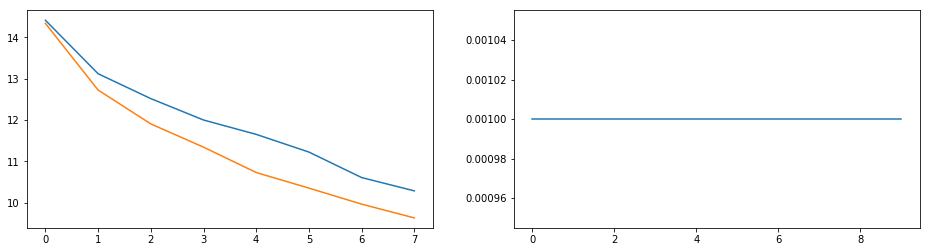

In [23]:
ls1 = parallel_model.history.history['loss']
val_ls1 = parallel_model.history.history['val_loss']
lr1 = parallel_model.history.history['lr']

fig, ax = plt.subplots(1,2, figsize=(16,4))
ax[0].plot(ls1[2:])
ax[0].plot(val_ls1[2:])

ax[1].plot(lr1)

In [ ]:
# now
test_imgs = os.listdir('../../coco-data/VOCdevkit/VOC2012/JPEGImages/')

ids = np.random.randint(len(test_imgs))
image = cv2.imread('../../coco-data/VOCdevkit/VOC2012/JPEGImages/' + test_imgs[ids])

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))


OBJ_THRESHOLD = 0.1
NMS_THRESHOLD = 0.45
input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = parallel_model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

In [43]:
# generator_config['BATCH_SIZE'] = 100
# train_batch = BatchGenerator(train_imgs_, generator_config, norm=normalize)
# valid_batch = BatchGenerator(valid_imgs_, generator_config, norm=normalize, jitter=False)

In [ ]:

# model = build_model(input_image, true_boxes)
# optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
# model.compile(loss = custom_loss,
#               optimizer=optimizer)#,

# print("building {} models...".format(GPUS))

EPOCHS = 100
print("let's start parallel model with {} epochs".format(EPOCHS))
parallel_model.fit_generator(generator        = train_batch, 
                             steps_per_epoch  = len(train_batch), 
                             initial_epoch    = 50,
                             epochs           = EPOCHS, 
                             verbose          = 1,
                             validation_data  = valid_batch,
                             validation_steps = len(valid_batch),
                             callbacks        = [reduce_lr, early_stop, checkpoint],
                             use_multiprocessing=True,
                             workers          = 8)


In [ ]:
np.save('../wts/weights_xception_coco2_14.npy', model.get_weights())
print("model saved successfully ")

ls2 = parallel_model.history.history['loss']
val_ls2 = parallel_model.history.history['val_loss']
lr2 = parallel_model.history.history['lr']

fig, ax = plt.subplots(1,2, figsize=(16,4))
ax[0].plot(ls2)
ax[0].plot(val_ls2)

ax[1].plot(lr2)

In [ ]:
# now
test_imgs = os.listdir('../../coco-data/VOCdevkit/VOC2012/JPEGImages/')

ids = np.random.randint(len(test_imgs))
image = cv2.imread('../../coco-data/VOCdevkit/VOC2012/JPEGImages/' + test_imgs[ids])

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))


OBJ_THRESHOLD = 0.1
NMS_THRESHOLD = 0.45
input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = parallel_model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

In [ ]:
# now
test_imgs = os.listdir('../../coco-data/VOCdevkit/VOC2012/JPEGImages/')

ids = np.random.randint(len(test_imgs))
image = cv2.imread('../../coco-data/VOCdevkit/VOC2012/JPEGImages/' + test_imgs[ids])

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))


OBJ_THRESHOLD = 0.1
NMS_THRESHOLD = 0.45
input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = parallel_model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

# increase lr_rate

In [ ]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999)
parallel_model.compile(loss = custom_loss,
                       optimizer=optimizer)#,

EPOCHS = 140
print("let's start parallel model again for another {} epochs".format(EPOCHS-100))
parallel_model.fit_generator(generator        = train_batch, 
                             steps_per_epoch  = len(train_batch),
                             initial_epoch    = 100
                             epochs           = EPOCHS, 
                             verbose          = 1,
                             validation_data  = valid_batch,
                             validation_steps = len(valid_batch),
                             callbacks        = [early_stop, checkpoint, reduce_lr],
                             use_multiprocessing=True,
                             workers          = 8)


In [ ]:
np.save('../wts/weights_xception_coco3_14.npy', model.get_weights())
print("model saved successfully ")

ls3 = parallel_model.history.history['loss']
val_ls3 = parallel_model.history.history['val_loss']
lr3 = parallel_model.history.history['lr']

fig, ax = plt.subplots(1,2, figsize=(16,4))
ax[0].plot(ls3)
ax[0].plot(val_ls3)

ax[1].plot(lr3)

In [ ]:
optimizer = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999)
parallel_model.compile(loss = custom_loss,
                       optimizer=optimizer)#,

print("let's start parallel model again for another 50 epochs")
parallel_model.fit_generator(generator        = train_batch, 
                             steps_per_epoch  = len(train_batch), 
                             epochs           = 60, 
                             verbose          = 1,
                             validation_data  = valid_batch,
                             validation_steps = len(valid_batch),
                             callbacks        = [early_stop, checkpoint, reduce_lr],
                             use_multiprocessing=True,
                             workers=4)

In [ ]:
ls3 = parallel_model.history.history['loss']
val_ls3 = parallel_model.history.history['val_loss']
lr3 = parallel_model.history.history['lr']

In [ ]:
plt.plot(ls1+ls2+ls3)

In [25]:
def predict(test_img, thresh=0.45):
#     thresh = 0.3
    image = cv2.imread(test_img)
    input_image = cv2.resize(image, (224, 224))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
    
    netout = parallel_model.predict([input_image, dummy_array])

    boxes = decode_netout(netout[0], 
                          obj_threshold=thresh,#OBJ_THRESHOLD,
                          nms_threshold=0.45,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    count = 1
    while not boxes:
        thresh = thresh -0.5*count
        boxes = decode_netout(netout[0], 
                              obj_threshold=thresh,#OBJ_THRESHOLD,
                              nms_threshold=0.3,
                              anchors=ANCHORS, 
                              nb_class=CLASS)
        count += 1
    if len(boxes)>1:
        score_ = boxes[0].get_score()
        index_  = 0
        for ii, bb in enumerate(boxes[1:]):
            score_1 = bb.get_score()
            if score_1>=score_:
                index_ = ii+1
                score_ = score_1
#         print(index_)
        return boxes[index_]
    else:
        return boxes

In [29]:
os.listdir('../../coco-data/VOCdevkit/VOC2012/JPEGImages/')

['2012_003700.jpg',
 '2009_004175.jpg',
 '2008_001274.jpg',
 '2011_003459.jpg',
 '2011_002979.jpg',
 '2010_006509.jpg',
 '2009_004748.jpg',
 '2010_005732.jpg',
 '2008_001997.jpg',
 '2008_007519.jpg',
 '2009_004419.jpg',
 '2010_006590.jpg',
 '2008_003914.jpg',
 '2008_000297.jpg',
 '2011_005686.jpg',
 '2012_003958.jpg',
 '2010_002814.jpg',
 '2007_004000.jpg',
 '2007_000042.jpg',
 '2009_004005.jpg',
 '2011_002317.jpg',
 '2009_004942.jpg',
 '2008_004885.jpg',
 '2011_001243.jpg',
 '2010_000690.jpg',
 '2010_004017.jpg',
 '2011_001875.jpg',
 '2010_002041.jpg',
 '2012_003722.jpg',
 '2008_002568.jpg',
 '2010_003845.jpg',
 '2008_007143.jpg',
 '2008_002864.jpg',
 '2012_004077.jpg',
 '2009_003087.jpg',
 '2010_006692.jpg',
 '2009_004738.jpg',
 '2011_002393.jpg',
 '2012_001678.jpg',
 '2008_002379.jpg',
 '2008_003572.jpg',
 '2009_004804.jpg',
 '2012_004229.jpg',
 '2012_001998.jpg',
 '2008_001546.jpg',
 '2011_006406.jpg',
 '2008_001318.jpg',
 '2009_002419.jpg',
 '2009_000171.jpg',
 '2007_009030.jpg',


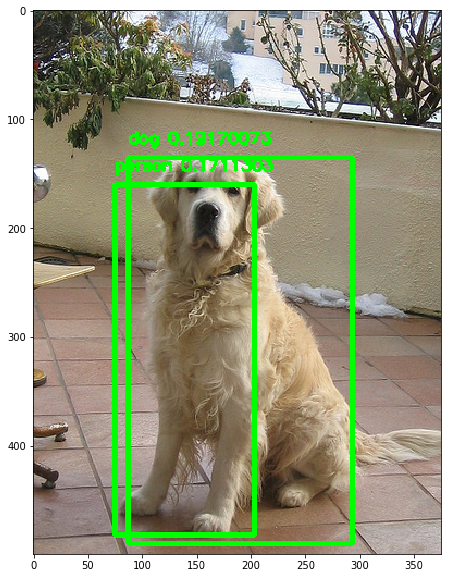

In [67]:
# now
image = cv2.imread('../../coco-data/VOCdevkit/VOC2012/JPEGImages/2010_000183.jpg')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))


OBJ_THRESHOLD = 0.1
NMS_THRESHOLD = 0.45
input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = parallel_model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

In [56]:
boxes[0].classes, boxes[1].classes

(array([0.27221778, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ], dtype=float32),
 array([0.8860882, 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       ],
       dtype=float32))

In [ ]:
def predict(test_img, thresh=0.3):
#     thresh = 0.3
    image = cv2.imread(test_img)
    input_image = cv2.resize(image, (224, 224))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
    
    netout = parallel_model.predict([input_image, dummy_array])

    boxes = decode_netout(netout[0], 
                          obj_threshold=thresh,#OBJ_THRESHOLD,
                          nms_threshold=0.3,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    count = 1
    while not boxes:
        thresh = thresh -0.5*count
        boxes = decode_netout(netout[0], 
                              obj_threshold=thresh,#OBJ_THRESHOLD,
                              nms_threshold=0.3,
                              anchors=ANCHORS, 
                              nb_class=CLASS)
        count += 1
    if len(boxes)>1:
        score_ = boxes[0].get_score()
        index_  = 0
        for ii, bb in enumerate(boxes[1:]):
            score_1 = bb.get_score()
            if score_1>=score_:
                index_ = ii+1
                score_ = score_1
#         print(index_)
        return boxes[index_]
    else:
        return boxes


import pandas as pd
box_pred = []

# test_dir = 'data/train/images/'
# df_test = pd.read_csv('data/level3_data/test.csv')
all_files = df_test['image_name'].values
print(len(all_files))


for ii, file_ in enumerate(all_files):
    box_pred.append(predict(test_dir + file_, 0.4))
    if (ii%2000) == 0:
        print("done till {} images".format(ii))
        
empty_pred_idx = []
box_pred_values = []
count = 0
for ii, box_ in enumerate(box_pred):
    image_h, image_w = 480, 640
#     if not box_:
#         print(ii)
#         count += 1
# count
    if box_:
        try:
#             print(box_[0])
            xmin = int(box_[0].xmin * image_w)
            ymin = int(box_[0].ymin * image_h)
            xmax = int(box_[0].xmax * image_w)
            ymax = int(box_[0].ymax * image_h)
        except:
#             print(box_)
            xmin = int(box_.xmin * image_w)
            ymin = int(box_.ymin * image_h)
            xmax = int(box_.xmax * image_w)
            ymax = int(box_.ymax * image_h)

    else:
        empty_pred_idx.append(ii)
        xmin, ymin, xmax, ymax = 999, 999, 999, 999#0, 0, 640, 480
        print("====",ii,"====")
    box_pred_values.append((xmin, ymin, xmax, ymax))
    
    if ii%2000 == 0:
        print("reached to {} boxes".format(ii))
    
box_pred_values = np.array(box_pred_values)
box_pred_values[3], box_pred_values.shape


df_pred = pd.DataFrame(columns=['x1','y1','x2','y2'], data=box_pred_values)
df_img = pd.DataFrame(data=all_files, columns=['image_name'])
sub = pd.concat([df_img, df_pred['x1'], df_pred['x2'], df_pred['y1'], df_pred['y2']], axis=1)
sub.head()




sub.x1 = np.where(sub.x1<-1,-1,sub.x1)
sub.y1 = np.where(sub.y1<-1, -1, sub.y1)
sub.x2 = np.where(sub.x2>640, 640, sub.x2)
sub.y2 = np.where(sub.y2>480, 480, sub.y2)

sub.to_csv('final-submission.csv',index=None)

print("done with prediction step")


In [ ]:
sub.head(10)

In [ ]:
fig, ax = plt.subplots(4,6,figsize=(20,12))
axes = ax.flatten()

for i in range(24):
    idx_r = np.random.randint(sub.shape[0])
    # now
    image = cv2.imread(test_dir + all_files[idx_r])
    box__ = sub.iloc[idx_r]
    xmin, ymin, xmax, ymax = box__['x1'], box__['y1'], box__['x2'],box__['y2']

    image = cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
    axes[i].imshow(image[:,:,::-1])
plt.show()